<a href="https://colab.research.google.com/github/mtwenzel/image-video-understanding/blob/master/Session_4_Generative_Adversarial_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks
* Idea: Optimize one network by letting it compete against another: the adversarial network.
* The two networks are usually named
    * The Generator network -- aims to generate an output that is indistinguishable from the desired output
    * The Discriminator network -- tries to tell the fake (Generator-produced) output from the true output
* Training: In each iteration, ...
    * A number of fake examples is generated;
    * A number of real examples is drawn from the train images;
    * The discriminator is trained for some iterations;
    * The adversarial model is trained (i.e. the generator is free to adjust weights while the discriminator weights are is fixed in some implementations, and the loss is the discrimination loss)

In [1]:
'''
DCGAN on MNIST using Keras
Code basis: Rowel Atienza; https://github.com/roatienza/Deep-Learning-Experiments
Adapted by Markus Wenzel, Fraunhofer MEVIS
'''

import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop, ADAM

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )


In [0]:
class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        print('*** Discriminator ***')
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        print('*** Generator ***')
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM


In [0]:
class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = self.read_mnist_keras()

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()


    def read_mnist_keras(self):
        from keras.datasets import mnist
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        return (x_train[5000:] / 255.).reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)


    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            # [mwenzel] note that the discriminator loss is not fixed -- both the generator and the discriminator are optimized!
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, 0]
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()


11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
*** Discriminator ***
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         


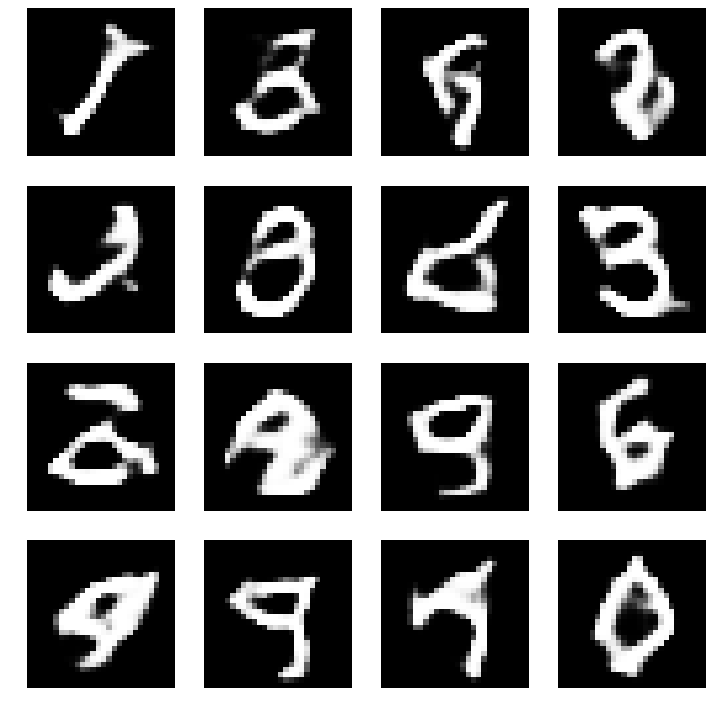

In [5]:
if __name__ == '__main__':
    mnist_dcgan = MNIST_DCGAN()
    timer = ElapsedTimer()
    mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=100)
    timer.elapsed_time()
    mnist_dcgan.plot_images(fake=True)
    mnist_dcgan.plot_images(fake=False, save2file=True)

# Assignment 1: Adapt to larger images.
Extend the DCGAN class so that the generator can generate images of arbitrary size. 
* For this, calculate the required `dims`.
* Add the parameter to the class definition.
* Create a new class liver_DCGAN to instantiate the new DCGAN appropriately, and to load the image data.

In [0]:
# Solution proposal

class DCGAN_new(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        assert self.img_rows == self.img_cols, "Input image has to be square, at least for now..."
        self.dims     = int(img_rows / 4)
        assert self.dims == img_rows / 4, "Input image extents have to be divisible by 4."
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.2
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.2
        depth = 64+64+64+64
        # In: 100
        # Out: dims x dims x depth
        self.G.add(Dense(self.dims*self.dims*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((self.dims, self.dims, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0001, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.00005, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM


In [9]:
%%bash 
test -e tmp_slices.npz || curl -L "https://drive.google.com/uc?export=download&id=1R2-H0dhhrj6XNK7Q-MazIWGeFDOf6Zya" --output tmp_slices.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    210      0 --:--:--  0:00:01 --:--:--   210
100 16.5M    0 16.5M    0     0  8030k      0 --:--:--  0:00:02 --:--:-- 70.2M


In [0]:
# Solution proposal

from os import listdir
from os.path import isfile, join
import numpy as np


class liver_DCGAN(object):
    def __init__(self):
        self.img_rows = 76
        self.img_cols = 76
        self.channel = 1
        
        TRAINING_SLICE_COUNT = 3000 

        loaded = np.load('tmp_slices.npz')

        self.x_train = loaded['x_train'][:TRAINING_SLICE_COUNT]
        self.y_train = loaded['y_train'][:TRAINING_SLICE_COUNT]

        self.x_test = loaded['x_train'][TRAINING_SLICE_COUNT:]
        self.y_test = loaded['y_train'][TRAINING_SLICE_COUNT:]

        assert len(self.x_train) == len(self.y_train)

        self.DCGAN = DCGAN_new(self.img_rows, self.img_cols)
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :]
            images_train = np.reshape(images_train, images_train.shape + (1,))
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'liver.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "liver_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()


In [0]:
if __name__ == '__main__':
    liver_dcgan = liver_DCGAN()
    timer = ElapsedTimer()
    liver_dcgan.train(train_steps=10000, batch_size=256, save_interval=50)
    timer.elapsed_time()
    liver_dcgan.plot_images(fake=True)
    liver_dcgan.plot_images(fake=False, save2file=True)

# Problems

* If you observe that the discriminator loss drops rapidly but the adversarial loss doesn't: why is this a problem? What is a solution?

[` `] Relatively lower the learning rate of the discriminator.

[` `] Relatively lower the learning rate of the generator.

[` `] Increase the learning rates of both generator and discriminator.

* What is the effect of 
  * (not) using dropout, 
  * of using it only in generator or discriminator, 
  * or using too high (> 0.6) values? 
  
Run experiments. (Attention: Run at least 500-1000 iterations before effects become apparent.)

# Assignment 2: Semantic Segmentation using Adversarial Training
Change the DCGAN so that it produces segmentations instead of fake originals.
* For this, replace the generator with a segmentation network.
* The adversarial net receives the original and generated segmentations.

Read "Semantic Segmentation using Adversarial Networks" (Luc et al. 2016). 

In [0]:
# Solution proposal
from keras.layers import UpSampling2D, MaxPool2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Input, concatenate
from keras.models import Model, Sequential
import keras.backend as K


def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    @url: https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)



class DCGAN_segmentation(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        assert self.img_rows == self.img_cols, "Input image has to be square, at least for now..."
        self.dims     = int(img_rows / 4)
        assert self.dims == img_rows / 4, "Input image extents have to be divisible by 4."
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model
        print("DCGAN_segmentation initialised.")

    def conv_bn_functional(self, model, filters=32, kernel_size=(3,3), batch_norm=True, activation='prelu', padding='same', kernel_regularizer=None):
        if batch_norm:
            model = BatchNormalization()(model)
        if activation == 'prelu':
            model = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='linear', kernel_regularizer=kernel_regularizer)(model)
            model = PReLU()(model)
        elif activation == 'lrelu':
            model = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='linear', kernel_regularizer=kernel_regularizer)(model)
            model = LeakyReLU()(model)
        else:
            model = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation, kernel_regularizer=kernel_regularizer)(model)
        return model

    def generator_functional(self, _filters=32, _filters_add=0, _kernel_size=(3,3), _padding='same', _activation='prelu', _kernel_regularizer=None, _final_layer_nonlinearity='sigmoid', _batch_norm=True):
        if self.G:
            return self.G

        input_layer = Input(shape=(self.img_rows,self.img_cols,1))

        x0 = self.conv_bn_functional(input_layer, filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
        x0 = self.conv_bn_functional(x0,          filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
        x1 = MaxPool2D()(x0)

        x1 = self.conv_bn_functional(x1,          filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
        x1 = self.conv_bn_functional(x1,          filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
        x2 = MaxPool2D()(x1)

        x2 = self.conv_bn_functional(x2,          filters=_filters+2*_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
        x2 = self.conv_bn_functional(x2,          filters=_filters+2*_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
        x3 = UpSampling2D()(x2)

        x3 = concatenate([x1,x3])
        x3 = self.conv_bn_functional(x3,          filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
        x3 = self.conv_bn_functional(x3,          filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
        x4 = UpSampling2D()(x3)

        x4 = concatenate([x0,x4])
        x4 = self.conv_bn_functional(x4,          filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
        x4 = self.conv_bn_functional(x4,          filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)

        output_layer = Conv2D(1, kernel_size=(1,1), activation=_final_layer_nonlinearity)(x4)

        self.G = Model(input_layer, output_layer)
        self.G.input_layer = input_layer
        self.G.output_layer = output_layer
        #self.G.summary()
        return self.G    
    
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.2
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        #self.D.summary()
        return self.D

    # The learning rate of discriminator and adversarial model need to be adjusted carefully.
    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.00001, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.DM
    
    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.00001, decay=3e-8)
        #optimizer = 'adadelta'

        discriminator_functional = self.discriminator_model().model
        self.AM = discriminator_functional(self.generator_functional(_activation='relu', _batch_norm=True).get_output_at(0))
        self.AM = Model(inputs=self.G.input_layer, outputs=[self.G.output_layer, self.AM])
        self.AM.compile(loss=[dice_coef_loss, 'binary_crossentropy'], loss_weights=[0.6, 0.4], optimizer=optimizer, metrics=['accuracy'])
        return self.AM


In [0]:
# Solution proposal

from os import listdir
from os.path import isfile, join
import numpy as np


class segmentation_DCGAN(object):
    def __init__(self):
        self.img_rows = 76
        self.img_cols = 76
        self.channel = 1
        
        self.load_data()

        self.DCGAN = DCGAN_segmentation(self.img_rows, self.img_cols)
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator_functional(_activation='relu', _batch_norm=True)

    def load_data(self):
        TRAINING_SLICE_COUNT = 3000 

        loaded = np.load('tmp_slices.npz')

        self.x_train = loaded['x_train'][:TRAINING_SLICE_COUNT]
        self.y_train = loaded['y_train'][:TRAINING_SLICE_COUNT]

        self.x_test = loaded['x_train'][TRAINING_SLICE_COUNT:]
        self.y_test = loaded['y_train'][TRAINING_SLICE_COUNT:]

        assert len(self.x_train) == len(self.y_train)
        
        
    def train(self, train_steps=2000, batch_size=256, save_interval=0, save2file=True, prefix='segmentation'):
        if save_interval>0:
            # Select a number of test images to predict
            rand_selection = np.random.randint(0, self.y_train.shape[0], size=16)
            originals_input = self.x_train[rand_selection, :, :]
            originals_input = np.reshape(originals_input, originals_input.shape + (1,))
        for i in range(train_steps):
            # images_train becomes the masks.
            # noise (the generator input) becomes the originals.
            # images_fake are the generator results -- the predicted masks.
            
            # (I) Train discriminator
            rand_selection = np.random.randint(0, self.x_train.shape[0], size=batch_size)
            originals_train = self.x_train[rand_selection, :, :]
            originals_train = np.reshape(originals_train, originals_train.shape + (1,))
            masks_train = self.y_train[rand_selection, :, :, np.newaxis]
            masks_fake = self.generator.predict(originals_train)
            x = np.concatenate((masks_train, masks_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)
            
            # (III) Train adversarial
            rand_selection = np.random.randint(0, self.y_train.shape[0], size=batch_size)
            y = np.ones([batch_size, 1])
            originals_train = self.x_train[rand_selection, :, :, np.newaxis]
            a_loss = self.adversarial.train_on_batch(originals_train, [masks_train, y])
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f/%f/%f, acc: %f/%f]" % (log_mesg, a_loss[0], a_loss[1], a_loss[2], a_loss[3], a_loss[4])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=save2file, samples=originals_input.shape[0],\
                        noise=originals_input, step=(i+1), prefix=prefix)

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0, prefix='segmentation'):
        filename = '%s.png' % prefix
        if fake:
            if noise is None:
                # Replace noise with random input images
                rand_selection = np.random.randint(0, self.x_train.shape[0], size=samples)
                originals_train = self.x_train[rand_selection, :, :]
                noise = np.reshape(originals_train, originals_train.shape + (1,))
            else:
                filename = "%s_%d.png" % (prefix, step)
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]
            images = np.reshape(images, images.shape + (1,))

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()


In [18]:
liver_dcgan = segmentation_DCGAN()

DCGAN_segmentation initialised.


/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


0: [D loss: 0.671012, acc: 0.670000]  [A loss: 0.460810/0.245798/0.783329, acc: 0.254507/0.000000]
1: [D loss: 0.672425, acc: 0.860000]  [A loss: 0.451020/0.243311/0.762584, acc: 0.263851/0.000000]
2: [D loss: 0.671730, acc: 0.945000]  [A loss: 0.446004/0.242211/0.751692, acc: 0.273200/0.000000]
3: [D loss: 0.672861, acc: 0.955000]  [A loss: 0.441913/0.238836/0.746529, acc: 0.290744/0.000000]
4: [D loss: 0.672406, acc: 0.960000]  [A loss: 0.438257/0.236064/0.741547, acc: 0.314199/0.000000]
5: [D loss: 0.671160, acc: 0.972500]  [A loss: 0.434985/0.235154/0.734731, acc: 0.323982/0.000000]
6: [D loss: 0.670617, acc: 0.972500]  [A loss: 0.432701/0.233043/0.732188, acc: 0.340673/0.000000]
7: [D loss: 0.670902, acc: 0.975000]  [A loss: 0.432731/0.234766/0.729679, acc: 0.340256/0.000000]
8: [D loss: 0.668396, acc: 0.970000]  [A loss: 0.428914/0.230162/0.727042, acc: 0.362970/0.000000]
9: [D loss: 0.668448, acc: 0.930000]  [A loss: 0.427760/0.230559/0.723562, acc: 0.369870/0.000000]
Elapsed: 1

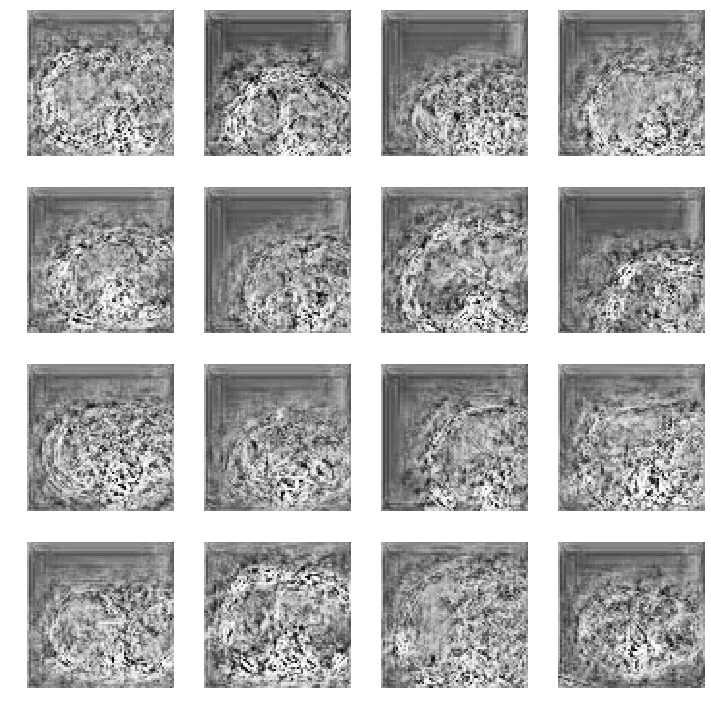

IndexError: ignored

In [21]:
timer = ElapsedTimer()
# Look at random batches of 200 slices each. 
liver_dcgan.train(train_steps=10, batch_size=200, save_interval=100, save2file=True, prefix='segmentation_60-40-rmsprop')
timer.elapsed_time()
liver_dcgan.plot_images(fake=True)
#liver_dcgan.plot_images(fake=False, save2file=True)